**ResNet**

ResNet is a Residual neural Network structure. It is an innovative neural network created for image classification.

The ResNet model architecture allows the training error to be reduced with a deeper network through connection skip.

Residual neural networks ignore some connections and make double or triple layer jumps that contain non-linearities (ReLU).

Resnet50 is trained on more than a million images from the ImageNet database.

Hardware used: T4 GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Librairies Installation and Import

In [ ]:
!pip install split-folders matplotlib opencv-python spicy

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt
import random
import shutil
import torch

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

Set seed which will be used for randomly spliting training and validation datasets, and model training.

In [ ]:
def seed_everything(seed):
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

# 2. Data Processing

## 2.1 Load and visualize

This step is to display an image of each class to see what it looks like. We have in total 4 classes.

In [ ]:
# Load labels for the dataset
train_labels = pd.read_csv("drive/MyDrive/940Final/labels.csv")
train_labels = train_labels.sort_values('label')
train_labels.head()

,id,label,source_img
743,743,0,train_266.png
745,745,0,train_266.png
759,759,0,train_451.png
708,708,0,train_604.png
710,710,0,train_199.png


In [ ]:
# Get classes
classes = list(train_labels.label.unique())
print(classes)

[0, 1, 2, 3]


By using a ResNet model, our dataset is split into 4 folders: 1 folder per class.

In [ ]:
# Create subfolders
for i in classes:
  os.makedirs(os.path.join('drive/MyDrive/940Final/black_bg_sub', str(i)))

# Move images to their respective classes
for c in classes:
  for i in list(train_labels[train_labels['label'] == c]['id']):
    get_image = os.path.join('drive/MyDrive/940Final/black_bg', str(i)+'.png')
    move_image_to_cat = shutil.copy(get_image, 'drive/MyDrive/940Final/black_bg_sub/'+str(c))

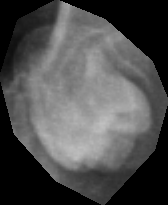

In [ ]:
# Class 0
img_0 = image.load_img("drive/MyDrive/940Final/black_bg_sub/0/296.png")
img_0.save("drive/MyDrive/940Final/for_report/class_0.png")
img_0

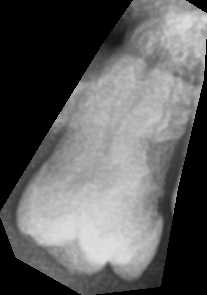

In [ ]:
# Class 1
img_1 = image.load_img("drive/MyDrive/940Final/black_bg_sub/1/180.png")
img_1.save("drive/MyDrive/940Final/for_report/class_1.png")
img_1

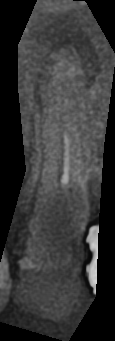

In [ ]:
# Class 2
img_2 = image.load_img("drive/MyDrive/940Final/black_bg_sub/2/916.png")
img_2.save("drive/MyDrive/940Final/for_report/class_2.png")
img_2

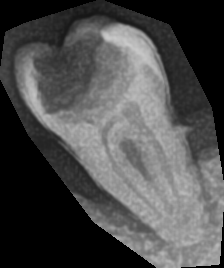

In [ ]:
# Class 3
img_3 = image.load_img("drive/MyDrive/940Final/black_bg_sub/3/3498.png")
img_3.save("drive/MyDrive/940Final/for_report/class_3.png")
img_3

## 2.2 Random split



Then we random split the images into train, validation and test sets. Train dataset: 70%; Validation dataset: 20%; Test dataset: 10%.

In [ ]:
# Split data in a new folder named data-split
splitfolders.ratio("drive/MyDrive/940Final/black_bg_sub",
                   output="drive/MyDrive/940Final/black_bg_sub_split",
                   seed=1337,
                   ratio=(0.7, 0.2, 0.1),
                   group_prefix=None,
                   move=False)

Copying files: 3529 files [01:03, 55.14 files/s]


## 2.3 Create Keras data generators

In [ ]:
seed_everything(42)

In [ ]:
datagen = ImageDataGenerator()

In [ ]:
class_names = ['0','1','2','3']

From the example images shown above, we have different size images. Here, we can resize the image to equal sizes.

In [ ]:
# training data
train_generator = datagen.flow_from_directory(
    directory="drive/MyDrive/940Final/black_bg_sub_split/train/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 2468 images belonging to 4 classes.


In [ ]:
# validation data
valid_generator = datagen.flow_from_directory(
    directory="drive/MyDrive/940Final/black_bg_sub_split/val/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 703 images belonging to 4 classes.


In [ ]:
# test data
test_generator = datagen.flow_from_directory(
    directory="drive/MyDrive/940Final/black_bg_sub_split/test/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 358 images belonging to 4 classes.


# 3. Build the Model

In [ ]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

# 4. Train the Model

We use the Adam optimizer and the sparse_categorical_crossentropy loss function.

In [ ]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [ ]:
# launch the training
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

Epoch 1/10
78/78 [==============================] - 1171s 15s/step - loss: 1.6819 - accuracy: 0.4822 - val_loss: 1.1291 - val_accuracy: 0.6615
Epoch 2/10
78/78 [==============================] - 18s 229ms/step - loss: 1.1560 - accuracy: 0.5790 - val_loss: 1.0634 - val_accuracy: 0.7340
Epoch 3/10
78/78 [==============================] - 19s 246ms/step - loss: 1.0271 - accuracy: 0.6317 - val_loss: 0.8586 - val_accuracy: 0.7440
Epoch 4/10
78/78 [==============================] - 18s 227ms/step - loss: 0.9414 - accuracy: 0.6823 - val_loss: 0.8441 - val_accuracy: 0.7411
Epoch 5/10
78/78 [==============================] - 19s 246ms/step - loss: 0.8992 - accuracy: 0.6985 - val_loss: 0.7417 - val_accuracy: 0.7468
Epoch 6/10
78/78 [==============================] - 19s 236ms/step - loss: 0.8491 - accuracy: 0.7099 - val_loss: 0.7126 - val_accuracy: 0.7454
Epoch 7/10
78/78 [==============================] - 18s 226ms/step - loss: 0.8098 - accuracy: 0.7322 - val_loss: 0.7138 - val_accuracy: 0.7482

Loss curves

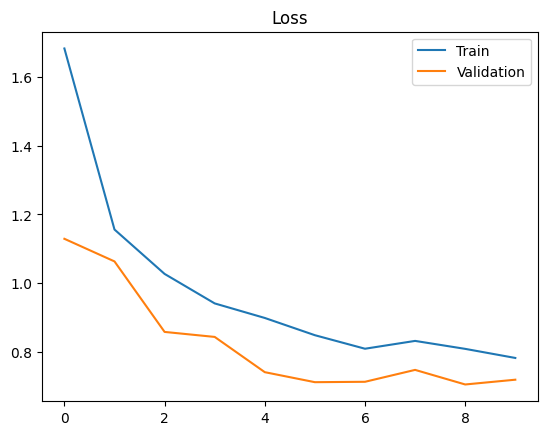

In [ ]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
x = np.arange(10)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, loss_train_curve, label = "Train")
ax.plot(x, loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title('Loss')
ax.legend()
plt.show()
fig.savefig('drive/MyDrive/940Final/for_report/loss_curve.png')

Accuracy curves

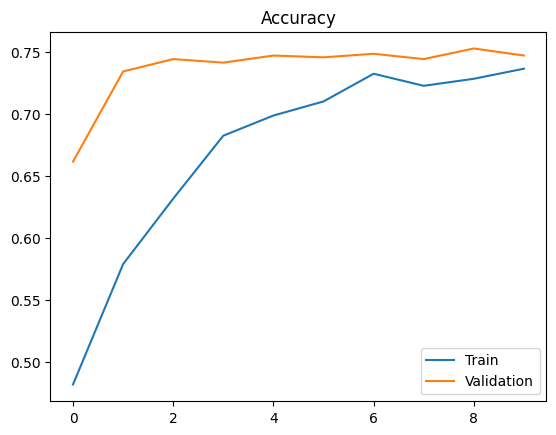

In [ ]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
x = np.arange(10)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, acc_train_curve, label = "Train")
ax.plot(x, acc_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title('Accuracy')
ax.legend()
plt.show()
fig.savefig('drive/MyDrive/940Final/for_report/accuracy_curve.png')

# 5. Evaluate the Model

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The test accuracy is: ", test_acc*100)

12/12 [==============================] - 125s 11s/step - loss: 0.7331 - accuracy: 0.7542
The test loss is:  0.7331453561782837
The best accuracy is:  75.41899681091309
